Loading BokehJS ...

Calculating mean for var: THETA from columns: ['D5TE_VWC_5cm_Avg', 'D5TE_VWC_15cm_Avg']
Calculating vapor pressure from vapor pressure deficit and air temperature
Calculating dew point temperature from vapor pressure


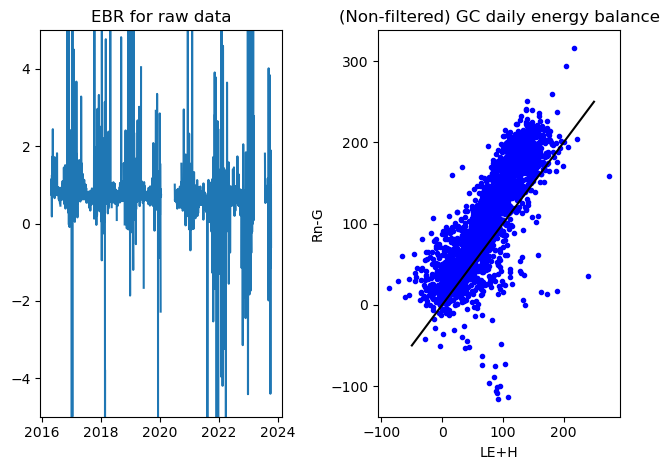

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from fluxdataqaqc import Data, QaQc, Plot
from bokeh.plotting import figure, show, ColumnDataSource
from bokeh.models.formatters import DatetimeTickFormatter
from bokeh.models import LinearAxis, Range1d
from bokeh.io import output_notebook
output_notebook()

import matplotlib.pyplot as plt

config_path = 'GC_config25m.ini.txt'
d = Data(config_path)

df = d.df.rename(columns=d.inv_map)
# get some metadata for saving
site_id = d.site_id
vars_we_want = ['H', 'LE', 'Rn', 'G']
# rename variables, calculate basice statistics table and save to HTML
df[vars_we_want].rename(columns=d.variables).describe().to_html('{}.html'.format(site_id))

doy_means = df[vars_we_want].groupby(d.df.index.dayofyear).mean()
# create a Bokeh figure
fig = figure(x_axis_label='day of year', y_axis_label='day of year mean (w/m2)')
# arguements needed for creating interactive plots
plt_vars = vars_we_want
colors = ['red', 'blue', 'black', 'green']
x_name = 'date'
source = ColumnDataSource(doy_means)
Plot.add_lines(fig, doy_means, plt_vars, colors, x_name, source, labels=vars_we_want,
    x_axis_type=None) 
show(fig)

doy_means = df[vars_we_want].groupby(d.df.index.dayofyear/365+d.df.index.year).mean()
# create a Bokeh figure
fig = figure(x_axis_label='day of year', y_axis_label='day of year mean (w/m2)')
# arguements needed for creating interactive plots
plt_vars = vars_we_want
colors = ['red', 'blue', 'black', 'green']
x_name = 'date'
source = ColumnDataSource(doy_means)
Plot.add_lines(fig, doy_means, plt_vars, colors, x_name, source, labels=vars_we_want,
    x_axis_type=None) 
show(fig)

EBR = (doy_means['LE']+doy_means['H'])/(doy_means['Rn']-doy_means['G'])

plt.subplot(1,2,1)
plt.plot(EBR)
plt.ylim([-5, 5])
plt.title('EBR for raw data')

plt.subplot(1,2,2)
plt.plot(doy_means['LE']+doy_means['H'],doy_means['Rn']-doy_means['G'],'.b')
plt.plot([-50,250],[-50,250],'-k')
plt.title('(Non-filtered) GC daily energy balance')
plt.xlabel('LE+H')
plt.ylabel('Rn-G')

plt.tight_layout()

And, the ``Data.inv_map`` maps the internal to user-defined names if they differ, however this is only created once the data is loaded by calling ``Data.df``. 

In [2]:
# creating a QaQc instance will automatically convert to daily
d.df = d.df.rename(columns=d.inv_map)
q = QaQc(d, daily_frac=22/24, max_interp_hours=2, max_interp_hours_night=6)
q.n_samples_per_day


q.correct_data(meth='ebr', et_gap_fill=False)
ebr_notgapfilled = q.df

ebr_notgapfilled.to_csv('CorrectedDaily_EBR_GC25mtower.csv')

Data is being resampled to daily temporal frequency.
Linearly interpolating gaps in energy balance components up to 6 hours when Rn < 0 and up to 2 hours when Rn >= 0.
Filtering days with less then 91.66666666666666% or 88/96 sub-daily measurements


In [9]:
ebr_notgapfilled.ebr_corr


date
2016-04-22    0.714866
2016-04-23     0.71959
2016-04-24    0.724659
2016-04-25    0.729826
2016-04-26    0.734627
                ...   
2023-10-07    1.022288
2023-10-08    1.022288
2023-10-09    1.022288
2023-10-10    1.022288
2023-10-11    1.022288
Freq: D, Name: ebr_corr, Length: 2729, dtype: object

In [4]:
q.monthly_df

,theta_mean,vp,Long_dn_corr,Long_up_corr,flux,flux_corr,t_min,ebr_5day_clim,rslt_wnd_spd,t_max,...,Hc_li,t_dew,T_tmpr_rh_mean,Precip_Tot,LE_subday_gaps,G_subday_gaps,H_subday_gaps,Rn_subday_gaps,ET,ET_corr
date,,,,,,,,,,,,,,,,,,,,,
2016-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-05-31,0.263039,1.301421,406.855452,351.290613,114.559637,124.465360,12.300573,0.731721,5.481566,21.485935,...,39.046117,9.684083,16.904301,84.582000,217.0,0.0,216.0,0.0,83.603547,90.813827
2016-06-30,0.253519,1.871040,450.017433,383.244011,141.020343,159.455348,18.514453,0.706495,4.464049,28.558173,...,24.506472,15.565684,23.932588,54.358000,82.0,1.0,68.0,0.0,123.586654,139.848375
2016-07-31,NaN,2.370363,444.597709,400.695238,132.519964,170.798580,18.855794,0.673726,3.390314,27.625242,...,17.621737,19.627999,23.654324,131.574000,252.0,0.0,230.0,0.0,125.942905,162.248164
2016-08-31,NaN,2.387696,447.962239,409.203327,120.947296,166.117627,19.781206,0.665387,3.298219,28.077494,...,20.782120,19.786890,24.101762,111.075214,121.0,0.0,118.0,0.0,109.782911,151.522080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-30,0.204824,1.455560,NaN,NaN,NaN,NaN,16.129147,0.707452,NaN,27.254287,...,NaN,11.750926,22.215432,35.052000,2880.0,0.0,2880.0,2880.0,NaN,NaN
2023-07-31,0.271482,2.168211,NaN,NaN,NaN,NaN,19.176973,0.674877,NaN,27.831665,...,NaN,18.086173,23.693971,113.116933,2574.0,0.0,2574.0,2633.0,NaN,NaN
2023-08-31,0.270542,2.134209,433.008953,385.684096,99.815076,135.111605,17.985797,0.664237,3.814966,26.978961,...,11.700149,17.798038,22.490862,87.118000,95.0,0.0,96.0,0.0,96.439366,130.870873


,count,mean,std,min,25%,50%,75%,max
date,,,,,,,,
1,122.0,2.151079,10.804251,-2.611809,0.261053,0.591787,1.084845,111.900528
2,97.0,0.665505,1.110908,-1.166449,0.189742,0.512194,0.757771,9.300534
3,138.0,0.741392,0.534784,-2.681213,0.574774,0.688606,0.835565,3.724365
4,135.0,0.742094,0.369607,-0.384067,0.619782,0.713705,0.833866,4.155223
5,154.0,0.803624,0.320291,0.442242,0.643540,0.759333,0.879518,3.309649
6,164.0,0.734850,0.199154,0.412657,0.626778,0.688300,0.825718,2.262292
7,195.0,0.671072,0.133555,0.148402,0.603367,0.682523,0.746562,1.022806
8,221.0,0.656025,0.127253,0.306580,0.570081,0.661682,0.741474,1.169486
9,209.0,0.616413,0.552855,-1.989967,0.575216,0.680419,0.813433,3.762110


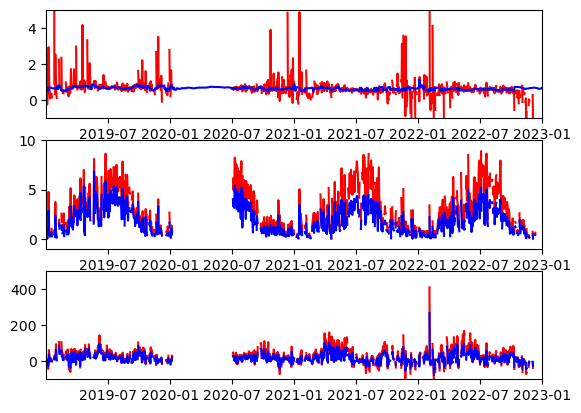

In [5]:
from datetime import datetime, timedelta

df_pick = ebr_notgapfilled

plt.figure(1)
plt.subplot(3,1,1)
plt.plot(df_pick.ebr,'r')
plt.plot(df_pick.ebr_corr,'b')
plt.ylim([-1,5])
plt.xlim([datetime(2019, 1, 1, 12, 0),datetime(2023, 1,1, 12, 0)])

plt.subplot(3,1,2)
plt.plot(df_pick.ET_corr,'r')
plt.plot(df_pick.ET,'b')
plt.xlim([datetime(2019, 1, 1, 12, 0),datetime(2023, 1,1, 12, 0)])
plt.ylim([-1,10])

plt.subplot(3,1,3)
plt.plot(df_pick.H_corr,'r')
plt.plot(df_pick.Hc_li,'b')
plt.xlim([datetime(2019, 1, 1, 12, 0),datetime(2023, 1,1, 12, 0)])
plt.ylim([-100,500])

df_pick.ebr.groupby(df_pick.index.month).describe() #monthly analysis of EBR



**Note:** there are several calculated variables above that may not look familiar, many are calculated by the energy balance closure correction routines and described in [Closure Algorithms](https://flux-data-qaqc.readthedocs.io/en/latest/closure_explanation.html#). Also, any other variables (not found in ``QaQc.agg_dict`` that exist in a ``QaQc.df`` before accessing ``QaQc.monthly_df`` the first time will be averaged in the monthly time series dataframe (``QaQc.monthly_df``).

## Same process for 10m height data (2021-2023)

Calculating mean for var: THETA from columns: ['D5TE_VWC_5cm_Avg', 'D5TE_VWC_15cm_Avg']



The input data temporal frequency appears to be less than daily.
Data is being resampled to daily temporal frequency.
Linearly interpolating gaps in energy balance components up to 6 hours when Rn < 0 and up to 2 hours when Rn >= 0.
Filtering days with less then 91.66666666666666% or 44/48 sub-daily measurements
48


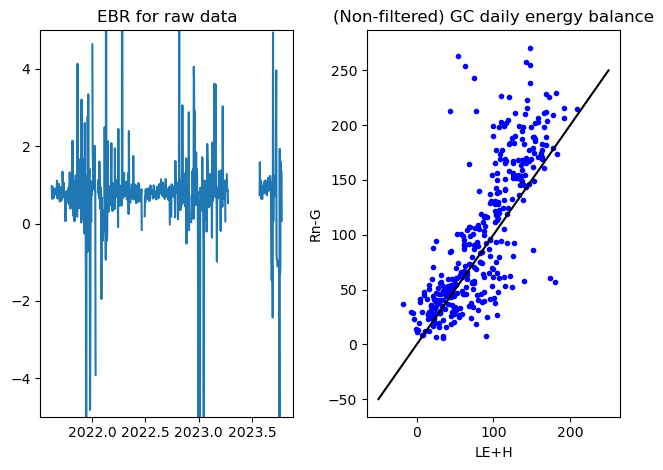

In [6]:
config_path = 'GC_config10m.ini'
d10 = Data(config_path)

df10 = d10.df.rename(columns=d10.inv_map)
# get some metadata for saving
site_id = d10.site_id
vars_we_want = ['H', 'LE', 'Rn', 'G']
# rename variables, calculate basice statistics table and save to HTML
df10[vars_we_want].rename(columns=d10.variables).describe().to_html('{}.html'.format(site_id))

doy_means = df10[vars_we_want].groupby(d10.df.index.dayofyear).mean()
# create a Bokeh figure
fig = figure(x_axis_label='day of year', y_axis_label='day of year mean (w/m2)')
# arguements needed for creating interactive plots
plt_vars = vars_we_want
colors = ['red', 'blue', 'black', 'green']
x_name = 'date'
source = ColumnDataSource(doy_means)
Plot.add_lines(fig, doy_means, plt_vars, colors, x_name, source, labels=vars_we_want,
    x_axis_type=None) 
show(fig)

doy_means2 = df10[vars_we_want].groupby(d10.df.index.dayofyear/365+d10.df.index.year).mean()


EBR = (doy_means2['LE']+doy_means2['H'])/(doy_means2['Rn']-doy_means2['G'])

plt.subplot(1,2,1)
plt.plot(EBR)
plt.ylim([-5, 5])
plt.title('EBR for raw data')

plt.subplot(1,2,2)
plt.plot(doy_means['LE']+doy_means['H'],doy_means['Rn']-doy_means['G'],'.b')
plt.plot([-50,250],[-50,250],'-k')
plt.title('(Non-filtered) GC daily energy balance')
plt.xlabel('LE+H')
plt.ylabel('Rn-G')

plt.tight_layout()


# creating a QaQc instance will automatically convert to daily
q10 = QaQc(d10, daily_frac=22/24, max_interp_hours=2, max_interp_hours_night=6)
print(q10.n_samples_per_day)


q10.correct_data(meth='ebr', et_gap_fill=False)
ebr_notgapfilled10 = q10.df

ebr_notgapfilled10.to_csv('CorrectedDaily_EBR_GC10mtower.csv')

AttributeError: 'DataFrame' object has no attribute 'input_H'

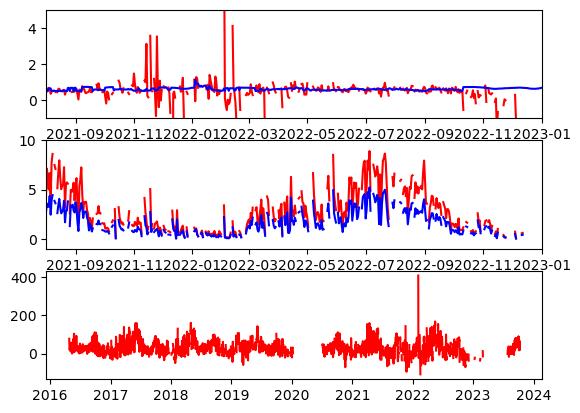

In [7]:
df_pick = ebr_notgapfilled

plt.figure(1)
plt.subplot(3,1,1)
plt.plot(df_pick.ebr,'r')
plt.plot(df_pick.ebr_corr,'b')
plt.ylim([-1,5])
plt.xlim([datetime(2021, 8, 1, 12, 0),datetime(2023, 1,1, 12, 0)])

plt.subplot(3,1,2)
plt.plot(df_pick.ET_corr,'r')
plt.plot(df_pick.ET,'b')
plt.xlim([datetime(2021, 8, 1, 12, 0),datetime(2023, 1,1, 12, 0)])
plt.ylim([-1,10])

plt.subplot(3,1,3)
plt.plot(df_pick.H_corr,'r')
plt.plot(df_pick.input_H,'b')
plt.xlim([datetime(2021, 8, 1, 12, 0),datetime(2023, 1,1, 12, 0)])
plt.ylim([-100,500])

df_pick.ebr.groupby(df_pick.index.month).describe() #monthly analysis of EBR

## Other calculations

By default, ``QaQc.correct_data`` also calculates ET from input latent energy (LE) and air temperature, corrected ET from corrected LE and air temperature, potential clear sky radiation (ASCE formulation), and the ``Data`` object attempts to calculate vapor pressure deficit from vapor pressure and air temperature or vapor pressure from vapor pressure deficit and air temperature if they exist at hourly or shorter temporal frequency. 

#### Evapotranspiration

The evapotranspiration (ET) calculations are described in [Step 8 of the energy balance ratio closure algorithm](https://flux-data-qaqc.readthedocs.io/en/latest/closure_explanation.html#steps-7-and-8-correct-turbulent-fluxes-ebr-and-et). 

#### ASCE clear sky radiation

Daily ASCE potential clear sky radiation ($R_{so}$) is calculated using equation 19 in the "ASCE Standardized Reference Evapotranspiration Equation" final report by the Task Committee on Standardization of Reference Evapotranspiration Environmental and Water Resources Institute of the American Society of Civil Engineers January, 2005 [here](https://www.mesonet.org/images/site/ASCE_Evapotranspiration_Formula.pdf). This calculation is a simple method based primarily on elevation and latitude which results in a theoretical envelope of $R_{so}$ as a function of the day of the year,

$$ R_{so} = \left(5 + 2 \times 10^{-5} z \right) R_a $$

where $z$ is elevation in meters and $R_a$ is daily extraterrestrial radiation (radiation with in the absence of an atmosphere), which itself is a well-behaved function of solar declination, the day of the year and the solar constant (see equations 21-29 in the [ASCE report](https://www.mesonet.org/images/site/ASCE_Evapotranspiration_Formula.pdf)). 

#### Vapor pressure/deficit

The ``Data`` object will attempt to calculate vapor pressure or vapor pressure deficit if one exists but not the other and average air temperature time series also exists with the input data at hourly or shorter temporal frequency. The Magnus equation (eqn. 37 in the ASCE report) states that the saturation vapor pressure ($es$) in kPa relates to air temperature,

$$ es = 0.6108  e^{\left(\frac{17.27 \cdot T}{(T + 237.3)}\right)} $$

where $T$ is average hourly air temperature in degrees celcius. Vapor pressure deficit ($vpd$) is,

$$ vpd = es - ea$$,

where $ea$ is actual vapor pressure in kPa. **Note,** The equations above are defined for hourly data however they are used for hourly or shorter mean variables ($T$, $ea$, or $vpd$) within ``flux-data-qaqc`` and then converted to daily means, if they are not present in the input data at hourly or shorter frequencies then they are not calculated.

The above equations can be rearanged to solve for either $es$ or $vpd$ given the other variable and air temperature.  For example, if given $T$ and $vpd$, then to get actual vapor pressure

$$ es = 0.6108  e^{\left(\frac{17.27 \cdot T}{(T + 237.3)}\right)}  $$

$$ ea = es - vpd. $$

In ``flux-data-qaqc`` actual vapor pressure is named "vp" not "ea".